*PyPlr* and Pupil Core
==========================
*PyPlr* works with [Pupil Core](https://pupil-labs.com/products/core/)—an affordable, open-source, versatile, research-grade eye tracking ecosystem with high sampling rates, precise model-based 3D estimation of pupil size, and many other features which make it well-suited to our application (see [Kassner et al., 2014](https://arxiv.org/abs/1405.0006), for a detailed overview of the system). In particular, we leverage real-time data streaming with the forward facing World Camera to timestamp the onset of light stimuli with good temporal accuracy, opening the door to integration with virtually any light source given a suitable geometry.

The best place to start learning more about Pupil Core is on the [Pupil Labs website](https://docs.pupil-labs.com/core/), but the features most relevant to *PyPlr* are:

* [Pupil Capture](https://docs.pupil-labs.com/core/software/pupil-capture/#world-window)—Software for interfacing with a Pupil Core headset.
* [Pupil Player](https://docs.pupil-labs.com/core/software/pupil-player/#load-a-recording)—Software for visualising and exporting data.
* [Pupil Core Network API](https://docs.pupil-labs.com/developer/core/network-api/)—Fast and reliable real-time communication and data streaming with [ZeroMQ](https://zeromq.org/) (an open source universal messaging library) and [MessagePack](https://msgpack.org/index.html) (a binary format for computer data interchange).

*PyPlr*'s `pupil.py` module
---------------------------
*PyPlr* has a module called `pupil.py` which facilitates working with the Pupil Core Network API by wrapping all of the tricky ZeroMQ and MessagePack stuff into a single device class called `PupilCore()`. This class has a `.command(...)` method giving convenient access to all of the commands available via [Pupil Remote](https://docs.pupil-labs.com/developer/core/network-api/#pupil-remote). With Pupil Capture already running, we can make a short recording as follows:

In [3]:
from time import sleep
from pyplr.pupil import PupilCore

p = PupilCore()

p.command('R our_recording')

sleep(10)

p.command('r')

'OK'

Annotations and notifications
-----------------------------
To extract experimental events and calculate time-critical PLR parameters (e.g., constriction latency, time-to-peak constriction) we need a reliable indication in the pupil data of the time at which a light stimulus was administered. The Pupil Labs [Annotation Capture](https://docs.pupil-labs.com/core/software/pupil-capture/#annotations) plugin helps us with this. The plugin allows timestamps to be marked with a label, which is basically the same as sending a 'trigger', 'message', or 'event marker'. Annotations can be made programmatically with `.new_annotation(...)` and sent with `.send_annotation(...)`. It's important to make sure that the Annotation Capture plugin has been enabled. You can do this manually in the Pupil Capture GUI or programmatically by sending a [notification message](https://docs.pupil-labs.com/developer/core/network-api/#notification-message), which is a special kind of message that the Pupil software uses to coordinate all activities. The following example shows how to enable the Annotation Capture plugin with a notification and then sends an annotation with the label `'my_event'` halfway through a 10 second recording.

In [12]:
p = PupilCore()

p.notify({'subject': 'start_plugin',
          'name': 'Annotation_Capture',
          'args': {}
          }) 

p.command('R our_recording')

sleep(5.)

annotation = p.new_annotation(
    label='my_event', 
    custom_fields={'whatever':'info','you':'want'})

p.send_annotation(annotation)

sleep(5.)

p.command('r')

'OK'

Once the recording is finished, we can open it with Pupil Player and use the [Annotation Player](https://docs.pupil-labs.com/core/software/pupil-player/#annotation-export) plugin to view and export the annotations to CSV format. Any custom labels assigned to the annotation will be included as a column in the exported CSV file. By default, the timestamp of an annotation made with the `.new_annotation(...)` method is set with ``.get_corrected_pupil_time(...)``, which gives the current pupil time (corrected for transmission delay), but this can be overridden at a later point if desired. 

Notifications can be used for many things, but there is no single exhaustive document. One way to find out what you can manipulate with a notification is to open [the codebase](https://github.com/pupil-labs/pupil) and search for `.notify_all(` and `def on_notify(`. Alternatively, you can subscribe to the properties of a plugin and then send a notification telling it to broadcast its properties. For example:

In [6]:
p = PupilCore()

s = p.subscribe_to_topic(topic='notify.pupil_detector.properties')

p.notify({
    'topic': 'notify.pupil_detector.broadcast_properties',
    'subject': 'pupil_detector.broadcast_properties',
    'eye_id': 0
    })

properties = p.recv_from_subscriber(s)
pprint(properties)

('notify.pupil_detector.properties.0.Detector2DPlugin',
 {'subject': 'pupil_detector.properties.0.Detector2DPlugin',
  'topic': 'notify.pupil_detector.properties.0.Detector2DPlugin',
  'values': {'blur_size': 5,
             'canny_aperture': 5,
             'canny_ration': 2,
             'canny_treshold': 160,
             'coarse_detection': True,
             'coarse_filter_max': 280,
             'coarse_filter_min': 128,
             'contour_size_min': 5,
             'ellipse_roundness_ratio': 0.1,
             'ellipse_true_support_min_dist': 2.5,
             'final_perimeter_ratio_range_max': 1.2,
             'final_perimeter_ratio_range_min': 0.6,
             'initial_ellipse_fit_treshhold': 1.8,
             'intensity_range': 23,
             'pupil_size_max': 100,
             'pupil_size_min': 10,
             'strong_area_ratio_range_max': 1.1,
             'strong_area_ratio_range_min': 0.6,
             'strong_perimeter_ratio_range_max': 1.1,
             'strong_

Bare in mind that for most use cases it will be best to verify manually in Pupil Capture that all of your most important settings are as they should be.

Getting pupil data in real-time
-------------------------------

The Pupil Capture continuously generates data from the camera frames it receives from a Pupil Core headset and makes them available via the [IPC backbone](https://docs.pupil-labs.com/developer/core/network-api/#reading-from-the-ipc-backbone). `PupilCore()` has a `.pupil_grabber(...)` method which simplifies access to these data. Just specify the topic of interest and how long you want to spend grabbing data:

In [15]:
p = PupilCore()
pgr_future = p.pupil_grabber(topic='pupil.1.3d', seconds=10)

Grabbing 10 seconds of pupil.1.3d
PupilGrabber done grabbing 10 seconds of pupil.1.3d


Crucially, `.pupil_grabber(...)` does its work in a thread using Python's `concurrent.futures` framework, returning a `Future` object that grants access to the data once the thread has concluded:

In [21]:
data = pgr_future.result()
data[0]

{'id': 1,
 'topic': 'pupil.1.3d',
 'method': 'pye3d 0.0.5 real-time',
 'norm_pos': [0.3985542681895381, 0.4872121928497438],
 'diameter': 31.07015699622092,
 'confidence': 1.0,
 'timestamp': 59132.475851,
 'sphere': {'center': [3.0121959398542617,
   3.0584489808353905,
   38.774452202770995],
  'radius': 10.392304845413264},
 'projected_sphere': {'center': [186.13898262425758, 146.6007379485103],
  'axes': [217.5786515706832, 217.5786515706832],
  'angle': 0.0},
 'circle_3d': {'center': [-3.473979035519928,
   -0.08232400147758101,
   31.286790400686012],
  'normal': [-0.624132478007217, -0.3022210211336496, -0.7205005928391071],
  'radius': 1.2067793333387498},
 'diameter_3d': 2.1463475823932923,
 'ellipse': {'center': [127.5373658206522, 123.06907371606148],
  'axes': [23.254159848837222, 31.07015699622092],
  'angle': 23.552991071760573},
 'location': [127.5373658206522, 123.06907371606148],
 'model_confidence': 1.0,
 'theta': 1.8778180987009694,
 'phi': -2.2846481119511255}

The data are returned as a list of dictionaries, with each dictionary representing a single [data point](https://docs.pupil-labs.com/developer/core/overview/#timing-data-conventions). With the `unpack_data_pandas(...)` helper function from `pyplr.utils`, we can organise the whole lot and inspect the pupil timecourse:

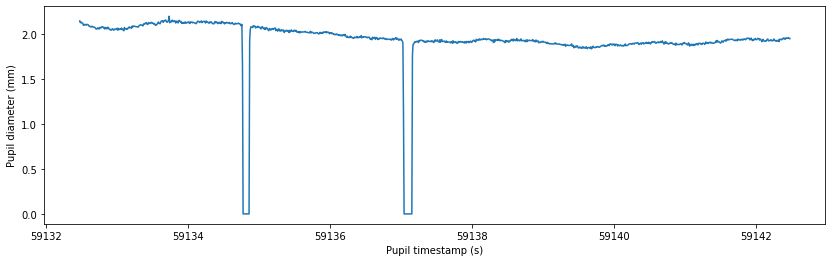

In [22]:
import matplotlib.pyplot as plt
from pyplr.utils import unpack_data_pandas

data = unpack_data_pandas(data)
ax = data['diameter_3d'].plot(figsize=(14,4))
ax.set_ylabel('Pupil diameter (mm)')
ax.set_xlabel('Pupil timestamp (s)')

Timestamping a light stimulus
-----------------------------
The simplest way to timestamp a light stimulus would be to control the light source programatically and send an annotation as close as possible to when we change the status of the light:

```Python
p = PupilCore()
p.command('R')
sleep(5.)
annotation = p.new_annotation('LIGHT_ON')
p.send_annotation(annotation)
my_light.on() # turn hypothetical light source on
sleep(1.)
my_light.off() # now turn it off
sleep(5.)
p.command('r')
```

But in reality this will be problematic as the light source will have a latency of its own, which is difficult to reference. In fact, the light source we have been using takes commands via generic HTTP requests and has a variable response time on the order of a few hundred miliseconds. Given that we may want to calculate pupil constriction latency to a light stimulus, which is typically around 200-300 ms, this variable latency is problematic.

To solve the issue and to make it easy to integrate *PyPlr* and Pupil Core with any light source, we developed a method called `.light_stamper(...)`. This method uses real-time data from the forward facing World Camera to timestamp light onsets based on the average RGB value.

In [5]:
p = PupilCore()

p.notify({'subject': 'start_plugin',
          'name': 'Annotation_Capture',
          'args': {}
         })

p.notify({'subject':'frame_publishing.set_format',
          'format':'bgr'})

p.command('R our_recording')

sleep(5.)

annotation = new_annotation(label='LIGHT_ON')

timeout = 10

lst_future = p.lightstamper(
    annotation=annotation,
    threshold=15,
    timeout=timeout,
    subscription='frame.world')

sleep(timeout)

p.command('r')

print(lst_future.result())

Waiting for a light to stamp...
Light stamped on frame.world at 678425.8230890001


(True, 678425.8230890001)

Like `.pupil_grabber(...)`, this method runs in its own thread with `concurrent.futures`. The underlying algorithm simply grabs frames from the World Camera and sends an annotation with the timestamp linked to the first frame where the average RGB value exceeds a given threshold. To work properly, the `.light_stamper(...)` requires a suitable stimulus geometry, an appropriately tuned threshold value, and the following settings in Pupil Capture:

* **Auto Exposure Mode** of the relevant camera must to be set to **Manual** 
* **Frame Publisher Format** must be set to **BGR**.

In our testing, `.light_stamper(...)` flawlessy captures the first frame where a light becomes visible, as verified using Pupil Player and the Annotation Player plugin. Timestamping accuracy therefore is limited only by frame rate and how well the Pupil software is able to synchronise 
the clocks of the eye and world cameras. Our light source has an LED channel with enough near infrared light that it can be detected by both eye and world cameras, so we were able to test this. Results...

`PupilCore(...)` also has some other cool features, like a `.fixation_trigger(...)` method that allow you to wait for a fixation that satisfies criteria relating to dispersion, duration and location of gaze samples. Check out the code for more insight!